# Niger/Millet DEV

# Imports

In [1]:
import numpy as np
import pandas as pd
from pcse.db import NASAPowerWeatherDataProvider
from pcse.util import reference_ET
import datetime
from matplotlib import pyplot as plt
from tqdm import tqdm as tqdm
import io
import xarray as xr
from sarra_py import *
import time
import geopandas as gpd

## 1. Defining simulation dates

In [2]:
date_start = datetime.date(2016,5,1)
duration = 220

## 2. Preparing the base dataset

In [3]:
# import zipfile

# path_to_zip_file = "../data/exemple_data/exemple_data_niger_2017.zip"
# directory_to_extract_to = "../data/exemple_data/"

# with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
#     zip_ref.extractall(directory_to_extract_to)

In [4]:
# we provide the path to the example data
# rainfall_data_path = "../data/exemple_data/TAMSAT_v3.1_niger_rfe_filled/"
# climate_data_path = "../data/exemple_data/AgERA5_niger/"

# alternatively, tap into the climate data that we already have retrieved for Niger, 1983-2022
rainfall_data_path = "/mnt/d/climate_database/TAMSAT_v3.1_niger_rfe_filled_1983_2021_DL20230614/"
climate_data_path = "/mnt/d/climate_database/AgERA5_niger_1981_2021_DL20230615/"

In [5]:
grid_width, grid_height = get_grid_size(rainfall_data_path, date_start, duration)
print("The grid is {} pixels wide by {} pixels high.".format(grid_width, grid_height))

The grid is 333 pixels wide by 437 pixels high.


In [6]:
# initialize empty xarray dataset
base_data = xr.Dataset()

# load rainfall and weather data
base_data = load_TAMSAT_data(base_data, rainfall_data_path, date_start, duration)
base_data = load_AgERA5_data(base_data, climate_data_path, date_start, duration)

100%|██████████| 5/5 [00:40<00:00,  8.09s/it]


In [7]:
base_data = load_iSDA_soil_data_alternate(base_data, grid_width, grid_height)

In [8]:
# compute day length raster
base_data = calc_day_length_raster_fast(base_data, date_start, duration)

In [9]:
base_data

<xarray.Dataset>
Dimensions:        (x: 437, y: 333, time: 220)
Coordinates:
  * x              (x) float64 -0.4875 -0.45 -0.4125 ... 15.79 15.83 15.86
  * y              (y) float64 23.77 23.74 23.7 23.66 ... 11.44 11.4 11.36 11.32
    spatial_ref    int64 0
Dimensions without coordinates: time
Data variables: (12/13)
    rain           (time, y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    tpMoy          (time, y, x) float32 nan nan nan nan ... 27.83 27.83 28.0
    ET0            (time, y, x) float32 nan nan nan nan ... 3.527 3.527 3.475
    rg             (time, y, x) float32 nan nan nan nan ... 21.26 21.26 21.28
    profRu         (y, x) float32 nan nan nan nan ... 400.0 400.0 750.0 750.0
    epaisseurSurf  (y, x) float32 200.0 200.0 200.0 200.0 ... 200.0 200.0 200.0
    ...             ...
    soil_type      (y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 6.0 6.0 6.0 6.0 6.0
    seuilRuiss     (y, x) float32 nan nan nan nan nan ... 15.0 15.0 15.0 15.0
    pourcRuiss     (y, x) float32 nan nan nan nan nan ... 0.35 0.35 0.35 0.35
    RZPAWC         (y, x) float32 nan nan nan nan nan ... 30.0 30.0 52.0 60.0
    ru             (y, x) float32 nan nan nan nan nan ... 75.0 75.0 69.33 80.0
    dureeDuJour    (time, y, x) float64 13.04 13.04 13.04 ... 11.48 11.48 11.48

## 3. Preparing a simulation dataset

In [10]:
# parameter file names
file_paramVariete = "millet_variety.yaml"
file_paramITK = "millet_niger_2017.yaml"
file_paramTypeSol = "USA_iowa_V42.yaml"

# load variety, cropping system and soil parameters
paramVariete, paramITK, paramTypeSol = load_YAML_parameters(file_paramVariete, file_paramITK, file_paramTypeSol)

In [11]:
# creato,g simulation xarray dataset by copying the base data
data = base_data.copy()

# initializing all the necessary variables
data = initialize_simulation(data, grid_width, grid_height, duration, paramVariete, paramITK, date_start)
data = initialize_default_irrigation(data)
data = calculate_once_daily_thermal_time(data, paramVariete)

In [12]:
data

<xarray.Dataset>
Dimensions:                             (x: 437, y: 333, time: 220)
Coordinates:
  * x                                   (x) float64 -0.4875 -0.45 ... 15.86
  * y                                   (y) float64 23.77 23.74 ... 11.36 11.32
    spatial_ref                         int64 0
Dimensions without coordinates: time
Data variables: (12/113)
    rain                                (time, y, x) float32 0.0 0.0 ... 0.0 0.0
    tpMoy                               (time, y, x) float32 nan nan ... 28.0
    ET0                                 (time, y, x) float32 nan nan ... 3.475
    rg                                  (time, y, x) float32 nan nan ... 21.28
    profRu                              (y, x) float32 nan nan ... 750.0 750.0
    epaisseurSurf                       (y, x) float32 200.0 200.0 ... 200.0
    ...                                  ...
    sumPP                               (time, y, x) float32 0.0 0.0 ... 0.0 0.0
    TigeUp                              (time, y, x) float32 0.0 0.0 ... 0.0 0.0
    UBTCulture                          (time, y, x) float32 0.0 0.0 ... 0.0 0.0
    lai                                 (time, y, x) float32 0.0 0.0 ... 0.0 0.0
    Ncrit                               (time, y, x) float32 0.0 0.0 ... 0.0 0.0
    irrigation                          (time, y, x) float32 0.0 0.0 ... 0.0 0.0

## 4. Running the model

In [13]:
data = run_model(paramVariete, paramITK, paramTypeSol, data, duration)

100%|██████████| 220/220 [05:16<00:00,  1.44s/it]


## 5. Mapping results

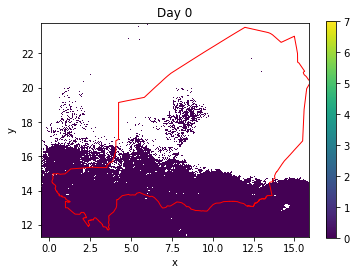

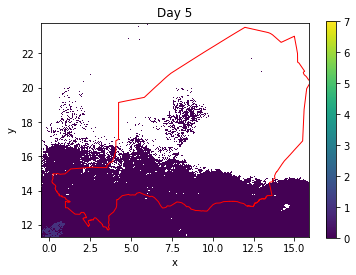

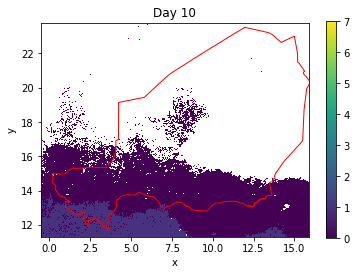

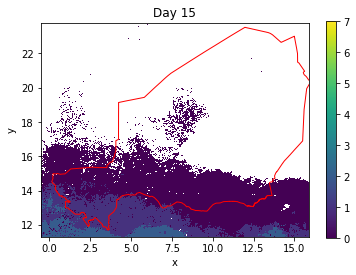

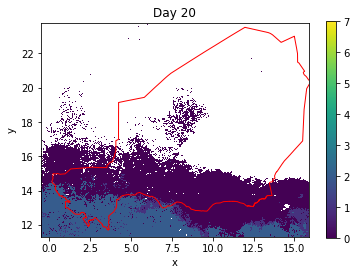

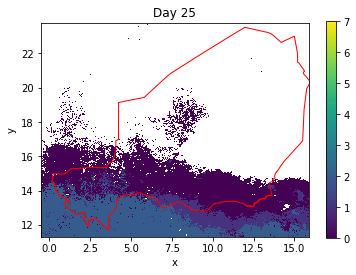

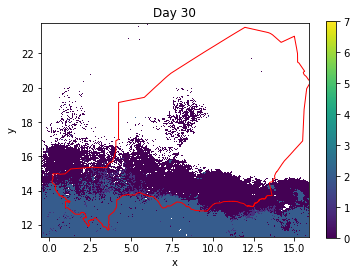

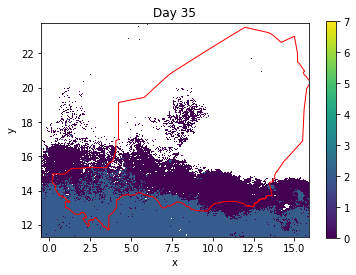

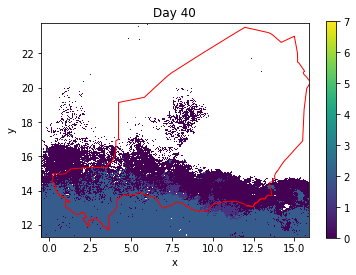

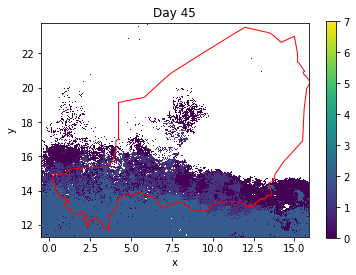

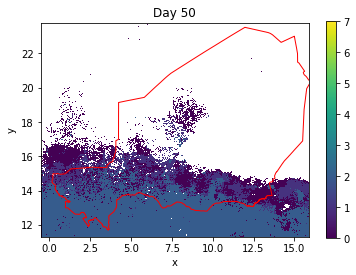

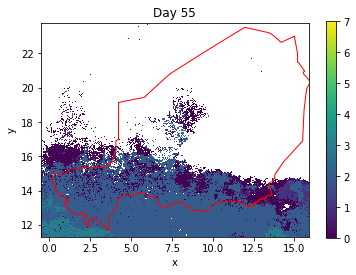

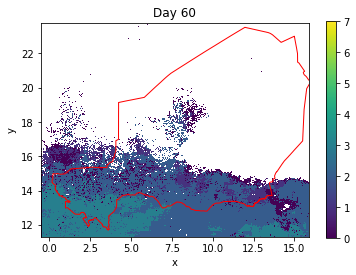

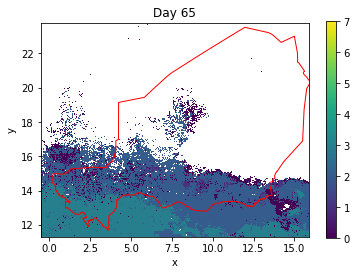

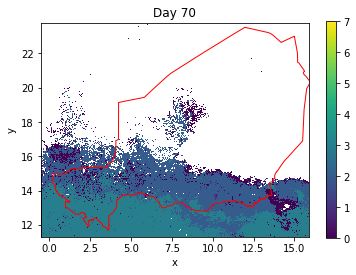

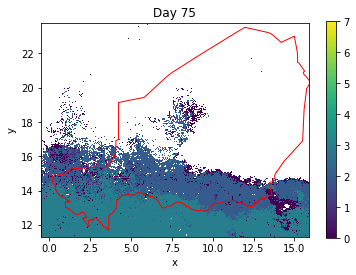

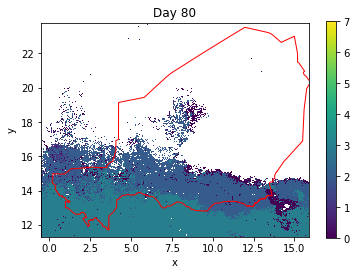

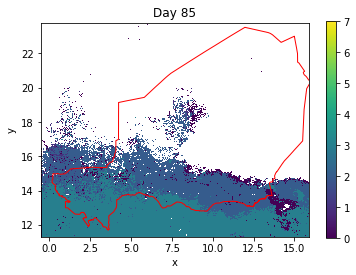

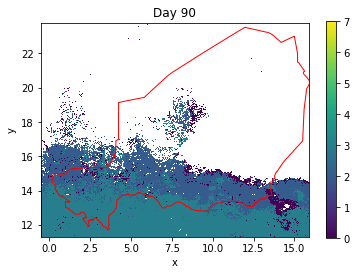

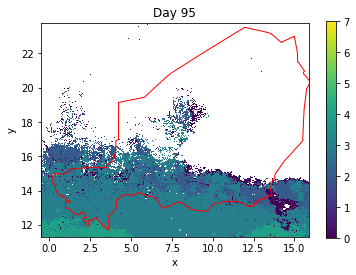

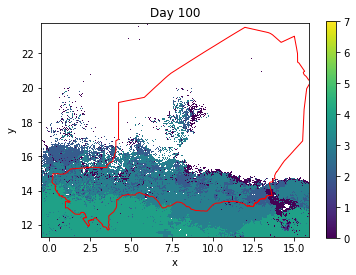

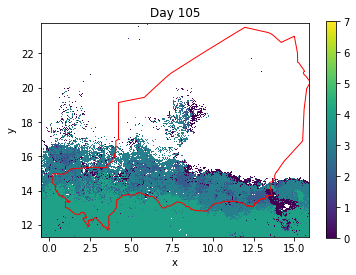

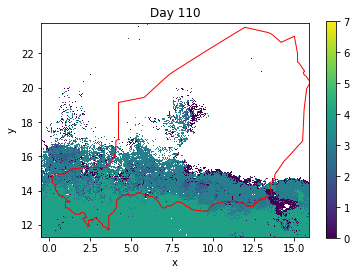

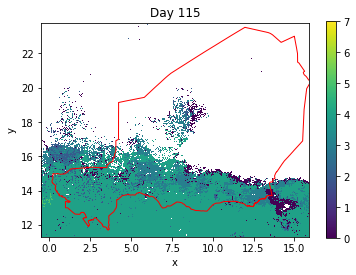

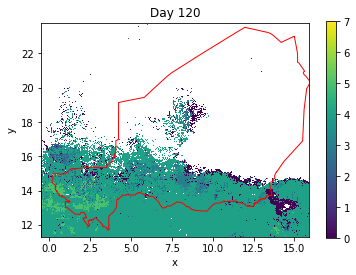

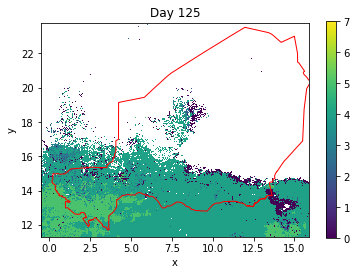

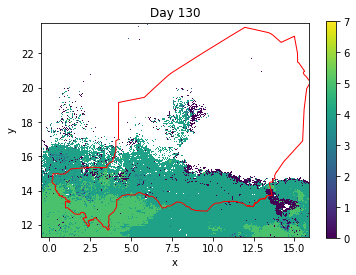

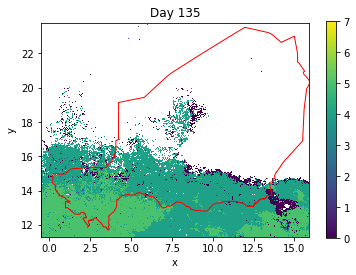

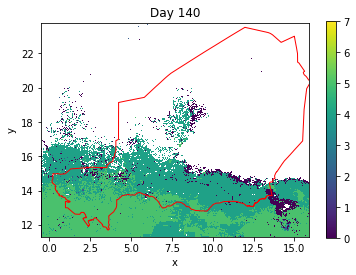

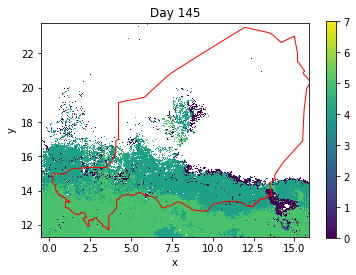

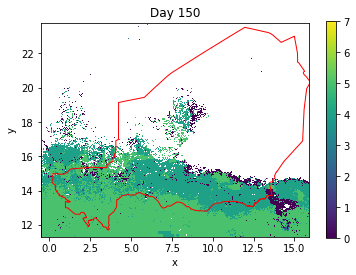

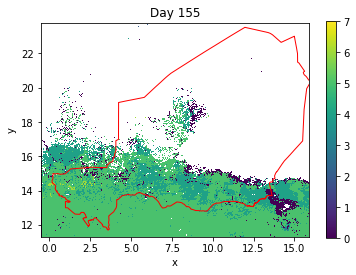

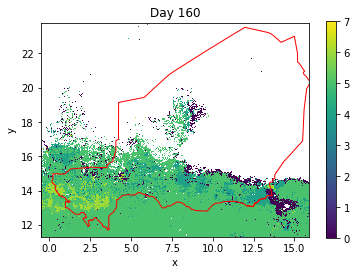

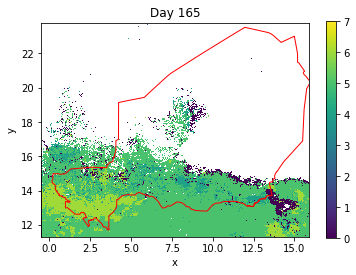

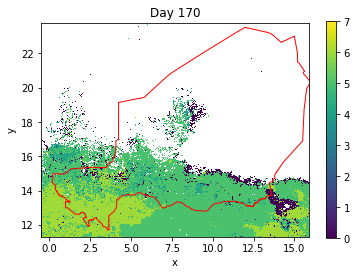

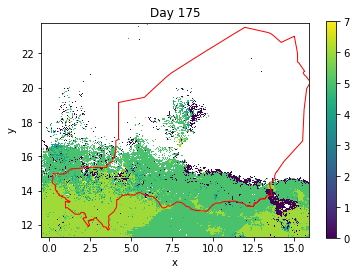

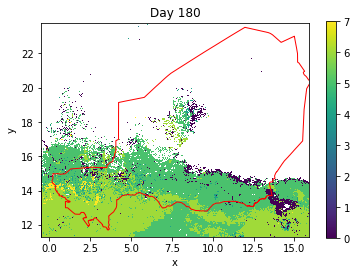

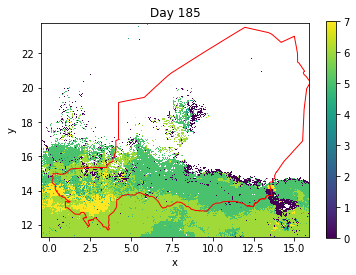

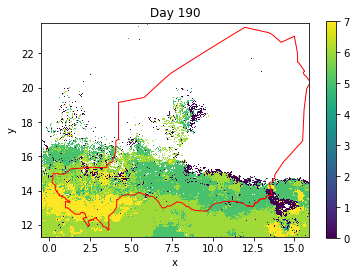

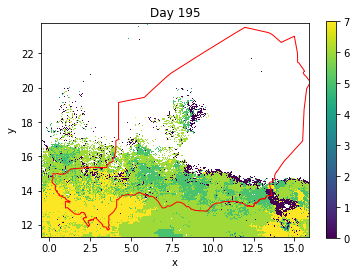

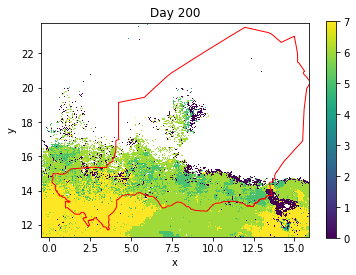

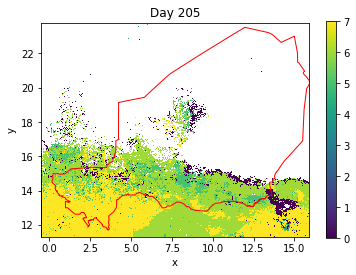

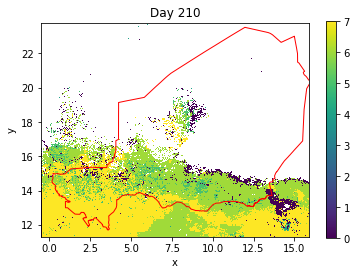

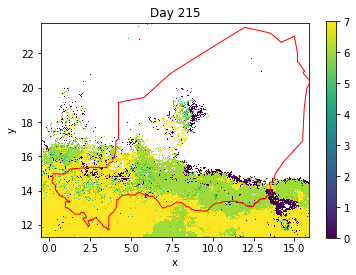

In [14]:
variable = "numPhase"
time_resolution = 5
vmax = data[variable].max().values
gdf = gpd.read_file("https://biogeo.ucdavis.edu/data/gadm3.6/shp/gadm36_NER_shp.zip")
for i in range(int(round(duration/time_resolution,0))):
    # data[variable][time_resolution*i,:,:].plot(vmin=0, vmax=vmax)
    xr.where(np.isnan(data["ru"]),np.nan,data[variable][time_resolution*i,:,:]).plot(vmin=0, vmax=vmax)
    gdf.plot(ax=plt.gca(), facecolor='none', edgecolor='red', linewidth=1.0)
    plt.title("Day %s" % (i*time_resolution))
    plt.show()

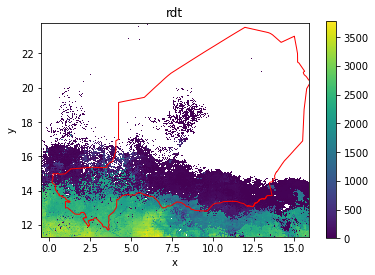

In [15]:
variable = "rdt"
gdf = gpd.read_file("https://biogeo.ucdavis.edu/data/gadm3.6/shp/gadm36_NER_shp.zip")

xr.where(np.isnan(data["ru"]),np.nan,data[variable][-1,:,:]).plot()
gdf.plot(ax=plt.gca(), facecolor='none', edgecolor='red', linewidth=1.0)
plt.title("%s" % (variable))
plt.show()